Using device: cuda
Number of classes: 9
Classes: [0 1 2 3 4 5 6 7 8]
Class distribution: [461 411 420 790 495 500 921 318 436]
Train size: 3230, Val size: 571, Test size: 951
Using ResNet50 with Transfer Learning
Model parameters: 23,116,809
Class weights: tensor([1.1430, 1.2817, 1.2593, 0.6683, 1.0681, 1.0556, 0.5742, 1.6615, 1.2084],
       device='cuda:0')

Starting training...


Epoch 1/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.09it/s, acc=0.683, loss=1.38]


Epoch 1/50 | Train Loss: 1.6287 | Train Acc: 0.4632 | Val Loss: 1.3790 | Val Acc: 0.6830
✓ Best model saved with val_acc: 0.6830


Epoch 2/50 [Val]: 100%|██████████| 36/36 [00:04<00:00,  8.58it/s, acc=0.734, loss=1.06]


Epoch 2/50 | Train Loss: 1.2874 | Train Acc: 0.6443 | Val Loss: 1.0562 | Val Acc: 0.7338
✓ Best model saved with val_acc: 0.7338


Epoch 3/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 18.29it/s, acc=0.783, loss=1.04]


Epoch 3/50 | Train Loss: 1.1799 | Train Acc: 0.7046 | Val Loss: 1.0395 | Val Acc: 0.7828
✓ Best model saved with val_acc: 0.7828


Epoch 4/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.64it/s, acc=0.797, loss=1.03] 


Epoch 4/50 | Train Loss: 1.1371 | Train Acc: 0.7375 | Val Loss: 1.0322 | Val Acc: 0.7968
✓ Best model saved with val_acc: 0.7968


Epoch 5/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.50it/s, acc=0.781, loss=1.06]


Epoch 5/50 | Train Loss: 1.1124 | Train Acc: 0.7517 | Val Loss: 1.0645 | Val Acc: 0.7811


Epoch 6/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.60it/s, acc=0.832, loss=0.97] 


Epoch 6/50 | Train Loss: 1.0455 | Train Acc: 0.7650 | Val Loss: 0.9699 | Val Acc: 0.8319
✓ Best model saved with val_acc: 0.8319


Epoch 7/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.41it/s, acc=0.79, loss=0.97]  


Epoch 7/50 | Train Loss: 1.0043 | Train Acc: 0.7879 | Val Loss: 0.9700 | Val Acc: 0.7898


Epoch 8/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.78it/s, acc=0.806, loss=0.995]


Epoch 8/50 | Train Loss: 0.9816 | Train Acc: 0.8080 | Val Loss: 0.9949 | Val Acc: 0.8056


Epoch 9/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.63it/s, acc=0.762, loss=1.03]


Epoch 9/50 | Train Loss: 0.9591 | Train Acc: 0.8183 | Val Loss: 1.0255 | Val Acc: 0.7618


Epoch 10/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.40it/s, acc=0.811, loss=0.99] 


Epoch 10/50 | Train Loss: 0.9501 | Train Acc: 0.8226 | Val Loss: 0.9898 | Val Acc: 0.8109


Epoch 11/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 21.00it/s, acc=0.86, loss=0.847] 


Epoch 11/50 | Train Loss: 0.8172 | Train Acc: 0.8771 | Val Loss: 0.8467 | Val Acc: 0.8599
✓ Best model saved with val_acc: 0.8599


Epoch 12/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.81it/s, acc=0.855, loss=0.858]


Epoch 12/50 | Train Loss: 0.8212 | Train Acc: 0.8728 | Val Loss: 0.8576 | Val Acc: 0.8546


Epoch 13/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.50it/s, acc=0.834, loss=0.887]


Epoch 13/50 | Train Loss: 0.7898 | Train Acc: 0.8935 | Val Loss: 0.8874 | Val Acc: 0.8336


Epoch 14/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.44it/s, acc=0.848, loss=0.908]


Epoch 14/50 | Train Loss: 0.7589 | Train Acc: 0.9015 | Val Loss: 0.9080 | Val Acc: 0.8476


Epoch 15/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.21it/s, acc=0.846, loss=0.878]


Epoch 15/50 | Train Loss: 0.7587 | Train Acc: 0.9059 | Val Loss: 0.8778 | Val Acc: 0.8459


Epoch 16/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.37it/s, acc=0.856, loss=0.852]


Epoch 16/50 | Train Loss: 0.7008 | Train Acc: 0.9313 | Val Loss: 0.8519 | Val Acc: 0.8564


Epoch 17/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.52it/s, acc=0.855, loss=0.864]


Epoch 17/50 | Train Loss: 0.6733 | Train Acc: 0.9384 | Val Loss: 0.8638 | Val Acc: 0.8546


Epoch 18/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.02it/s, acc=0.855, loss=0.855]


Epoch 18/50 | Train Loss: 0.6780 | Train Acc: 0.9325 | Val Loss: 0.8547 | Val Acc: 0.8546


Epoch 19/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.28it/s, acc=0.87, loss=0.812] 


Epoch 19/50 | Train Loss: 0.6664 | Train Acc: 0.9424 | Val Loss: 0.8117 | Val Acc: 0.8704
✓ Best model saved with val_acc: 0.8704


Epoch 20/50 [Val]: 100%|██████████| 36/36 [00:02<00:00, 16.94it/s, acc=0.867, loss=0.824]


Epoch 20/50 | Train Loss: 0.6704 | Train Acc: 0.9362 | Val Loss: 0.8238 | Val Acc: 0.8669


Epoch 21/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.14it/s, acc=0.869, loss=0.824]


Epoch 21/50 | Train Loss: 0.6556 | Train Acc: 0.9455 | Val Loss: 0.8243 | Val Acc: 0.8687


Epoch 22/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 19.85it/s, acc=0.872, loss=0.826]


Epoch 22/50 | Train Loss: 0.6405 | Train Acc: 0.9458 | Val Loss: 0.8263 | Val Acc: 0.8722
✓ Best model saved with val_acc: 0.8722


Epoch 23/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.30it/s, acc=0.876, loss=0.81] 


Epoch 23/50 | Train Loss: 0.6466 | Train Acc: 0.9452 | Val Loss: 0.8099 | Val Acc: 0.8757
✓ Best model saved with val_acc: 0.8757


Epoch 24/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.28it/s, acc=0.895, loss=0.773]


Epoch 24/50 | Train Loss: 0.6466 | Train Acc: 0.9480 | Val Loss: 0.7732 | Val Acc: 0.8949
✓ Best model saved with val_acc: 0.8949


Epoch 25/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.79it/s, acc=0.876, loss=0.828]


Epoch 25/50 | Train Loss: 0.6351 | Train Acc: 0.9508 | Val Loss: 0.8283 | Val Acc: 0.8757


Epoch 26/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 19.90it/s, acc=0.874, loss=0.808]


Epoch 26/50 | Train Loss: 0.6249 | Train Acc: 0.9594 | Val Loss: 0.8079 | Val Acc: 0.8739


Epoch 27/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.03it/s, acc=0.877, loss=0.817]


Epoch 27/50 | Train Loss: 0.6338 | Train Acc: 0.9613 | Val Loss: 0.8172 | Val Acc: 0.8774


Epoch 28/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 19.29it/s, acc=0.865, loss=0.845]


Epoch 28/50 | Train Loss: 0.6128 | Train Acc: 0.9613 | Val Loss: 0.8451 | Val Acc: 0.8651


Epoch 29/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 19.81it/s, acc=0.883, loss=0.804]


Epoch 29/50 | Train Loss: 0.6119 | Train Acc: 0.9613 | Val Loss: 0.8037 | Val Acc: 0.8827


Epoch 30/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 19.84it/s, acc=0.905, loss=0.763]


Epoch 30/50 | Train Loss: 0.5990 | Train Acc: 0.9669 | Val Loss: 0.7626 | Val Acc: 0.9054
✓ Best model saved with val_acc: 0.9054


Epoch 31/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 19.67it/s, acc=0.897, loss=0.758]


Epoch 31/50 | Train Loss: 0.5858 | Train Acc: 0.9749 | Val Loss: 0.7576 | Val Acc: 0.8967


Epoch 32/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.49it/s, acc=0.897, loss=0.785]


Epoch 32/50 | Train Loss: 0.5961 | Train Acc: 0.9684 | Val Loss: 0.7852 | Val Acc: 0.8967


Epoch 33/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.40it/s, acc=0.902, loss=0.768]


Epoch 33/50 | Train Loss: 0.5896 | Train Acc: 0.9712 | Val Loss: 0.7681 | Val Acc: 0.9019


Epoch 34/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.32it/s, acc=0.898, loss=0.756]


Epoch 34/50 | Train Loss: 0.5855 | Train Acc: 0.9715 | Val Loss: 0.7564 | Val Acc: 0.8984


Epoch 35/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.28it/s, acc=0.891, loss=0.765]


Epoch 35/50 | Train Loss: 0.5901 | Train Acc: 0.9700 | Val Loss: 0.7655 | Val Acc: 0.8914


Epoch 36/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.61it/s, acc=0.895, loss=0.759]


Epoch 36/50 | Train Loss: 0.5846 | Train Acc: 0.9737 | Val Loss: 0.7590 | Val Acc: 0.8949


Epoch 37/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.24it/s, acc=0.898, loss=0.76] 


Epoch 37/50 | Train Loss: 0.5777 | Train Acc: 0.9724 | Val Loss: 0.7604 | Val Acc: 0.8984


Epoch 38/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.43it/s, acc=0.884, loss=0.769]


Epoch 38/50 | Train Loss: 0.5698 | Train Acc: 0.9765 | Val Loss: 0.7693 | Val Acc: 0.8844


Epoch 39/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.26it/s, acc=0.888, loss=0.773]


Epoch 39/50 | Train Loss: 0.5720 | Train Acc: 0.9793 | Val Loss: 0.7728 | Val Acc: 0.8879


Epoch 40/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 20.68it/s, acc=0.891, loss=0.767]


Epoch 40/50 | Train Loss: 0.5820 | Train Acc: 0.9737 | Val Loss: 0.7668 | Val Acc: 0.8914
Early stopping triggered at epoch 40!


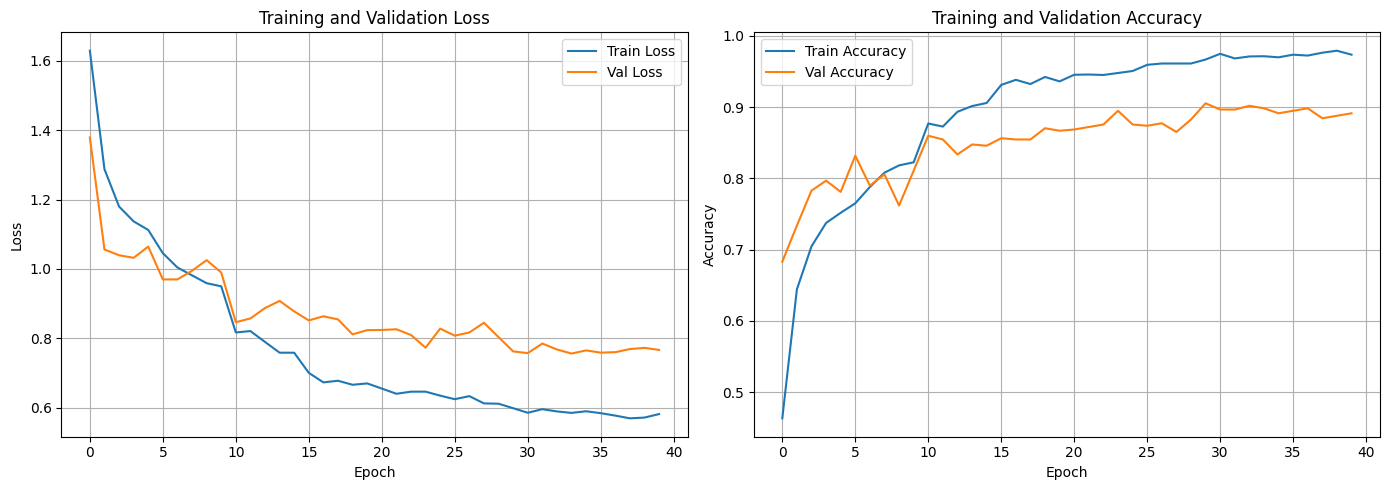


Loaded best model from epoch 30


Testing: 100%|██████████| 60/60 [00:02<00:00, 20.07it/s]



Test Accuracy: 88.85%



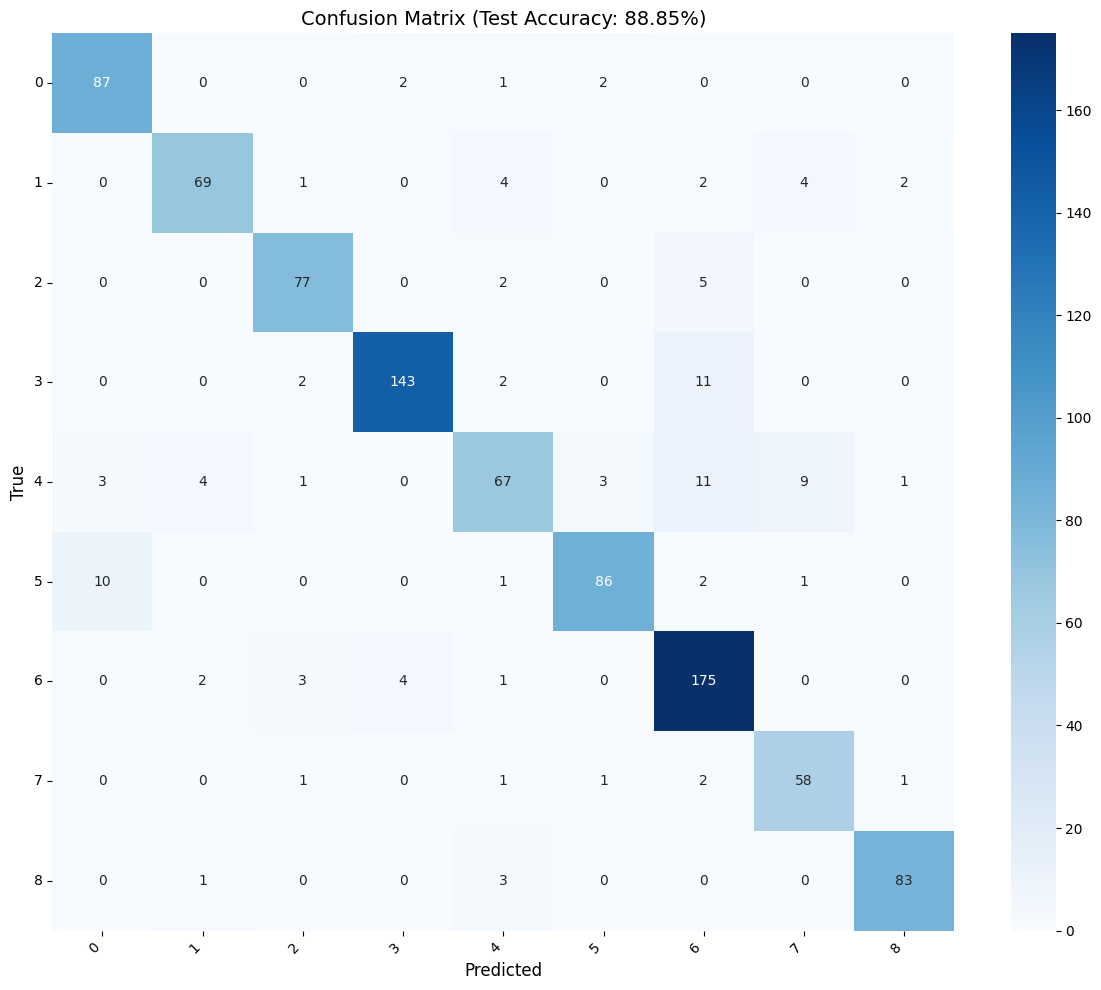


Classification Report:
              precision    recall  f1-score   support

           0     0.8700    0.9457    0.9062        92
           1     0.9079    0.8415    0.8734        82
           2     0.9059    0.9167    0.9112        84
           3     0.9597    0.9051    0.9316       158
           4     0.8171    0.6768    0.7403        99
           5     0.9348    0.8600    0.8958       100
           6     0.8413    0.9459    0.8906       185
           7     0.8056    0.9062    0.8529        64
           8     0.9540    0.9540    0.9540        87

    accuracy                         0.8885       951
   macro avg     0.8885    0.8835    0.8840       951
weighted avg     0.8904    0.8885    0.8874       951


Per-Class Accuracy:
0                   :  94.57% (92 samples)
1                   :  84.15% (82 samples)
2                   :  91.67% (84 samples)
3                   :  90.51% (158 samples)
4                   :  67.68% (99 samples)
5                   :  86.00% (100

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 0. Device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 1. Load data
# ---------------------------
image_array = np.load("images.npy", allow_pickle=True)
labels = np.load("labels.npy", allow_pickle=True)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")
print(f"Classes: {encoder.classes_}")
print(f"Class distribution: {np.bincount(y)}")

# Train/Val/Test split
train_idx, test_idx = train_test_split(
    np.arange(len(y)), test_size=0.2, random_state=42, stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.15, random_state=42, stratify=y[train_idx]
)

print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}, Test size: {len(test_idx)}")

# ---------------------------
# 2. Dataset class
# ---------------------------
class WasteDataset(Dataset):
    def __init__(self, images, labels, indices, transform=None):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        img = self.images[i].astype(np.uint8)
        label = self.labels[i]
        img = np.expand_dims(img, axis=-1)  # (H,W,1)
        if self.transform:
            img = self.transform(img)
        return img, label

# ---------------------------
# 3. Enhanced Transforms
# ---------------------------
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB for pretrained models
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = WasteDataset(image_array, y, train_idx, transform=train_transform)
val_dataset = WasteDataset(image_array, y, val_idx, transform=val_transform)
test_dataset = WasteDataset(image_array, y, test_idx, transform=val_transform)

# Increase batch size and add workers
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0, pin_memory=True)

# ---------------------------
# 4. Model Selection
# ---------------------------
# Option 1: Custom Improved CNN
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.adapt_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.fc1 = nn.Linear(512*4*4, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = self.adapt_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Option 2: Transfer Learning with ResNet50 (RECOMMENDED)
def create_resnet_model(num_classes, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last few layers for fine-tuning
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.layer3.parameters():
        param.requires_grad = True
    
    # Replace final layer
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

# Option 3: EfficientNet (Alternative)
def create_efficientnet_model(num_classes, pretrained=True):
    model = models.efficientnet_b0(pretrained=pretrained)
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last layers
    for param in model.features[-3:].parameters():
        param.requires_grad = True
    
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.classifier[1].in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model

# Choose model (change here to try different models)
USE_TRANSFER_LEARNING = True

if USE_TRANSFER_LEARNING:
    print("Using ResNet50 with Transfer Learning")
    model = create_resnet_model(num_classes, pretrained=True)
else:
    print("Using Custom Improved CNN")
    model = ImprovedCNN(num_classes, input_channels=3)

model = model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ---------------------------
# 5. Label Smoothing Loss
# ---------------------------
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, weight=None):
        super().__init__()
        self.epsilon = epsilon
        self.weight = weight
    
    def forward(self, output, target):
        n_class = output.size(1)
        log_preds = F.log_softmax(output, dim=1)
        loss = -log_preds.sum(dim=1).mean()
        nll = F.nll_loss(log_preds, target, weight=self.weight)
        return (1 - self.epsilon) * nll + self.epsilon * loss / n_class

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y[train_idx]),
    y=y[train_idx]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

# Use label smoothing
criterion = LabelSmoothingCrossEntropy(epsilon=0.1, weight=class_weights)

# ---------------------------
# 6. Optimizer with different learning rates
# ---------------------------
if USE_TRANSFER_LEARNING:
    # Different learning rates for different layers
    optimizer = optim.Adam([
        {'params': model.fc.parameters(), 'lr': 0.001},
        {'params': model.layer4.parameters(), 'lr': 0.0001},
        {'params': model.layer3.parameters(), 'lr': 0.00005}
    ], weight_decay=1e-4)
else:
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7
)

# Cosine annealing (alternative scheduler)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# ---------------------------
# 7. Training loop with all improvements
# ---------------------------
num_epochs = 50
best_val_acc = 0
patience = 10
trigger_times = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), 
                desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for i, (X_batch, y_batch) in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    
    with torch.no_grad():
        for X_batch, y_batch in loop_val:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            loop_val.set_postfix(loss=val_loss/total, acc=correct/total)

    val_loss = val_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, "best_model.pth")
        print(f"✓ Best model saved with val_acc: {val_acc:.4f}")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

# ---------------------------
# 8. Plot training history
# ---------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 9. Test evaluation
# ---------------------------
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")

model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    loop_test = tqdm(test_loader, desc="Testing")
    for X_batch, y_batch in loop_test:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n{'='*50}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"{'='*50}\n")

# ---------------------------
# 10. Confusion matrix
# ---------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix (Test Accuracy: {test_acc*100:.2f}%)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 11. Classification report
# ---------------------------
print("\nClassification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=[str(c) for c in encoder.classes_], digits=4))

# ---------------------------
# 12. Per-class accuracy
# ---------------------------
print("\nPer-Class Accuracy:")
print("="*70)
for i, class_name in enumerate(encoder.classes_):
    class_mask = np.array(y_true) == i
    if class_mask.sum() > 0:
        class_acc = np.mean(np.array(y_pred)[class_mask] == i)
        print(f"{str(class_name):20s}: {class_acc*100:6.2f}% ({class_mask.sum()} samples)")

print("\n✓ Training complete!")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Final test accuracy: {test_acc*100:.2f}%")

Using device: cuda
Number of classes: 9
Classes: [0 1 2 3 4 5 6 7 8]
Class distribution: [461 411 420 790 495 500 921 318 436]
Train size: 3230, Val size: 571, Test size: 951
Using Custom Improved CNN
Model parameters: 8,242,185
Class weights: tensor([1.1430, 1.2817, 1.2593, 0.6683, 1.0681, 1.0556, 0.5742, 1.6615, 1.2084],
       device='cuda:0')

Starting training...


Epoch 1/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.61it/s, acc=0.0858, loss=2.3] 


Epoch 1/50 | Train Loss: 2.3357 | Train Acc: 0.1056 | Val Loss: 2.3017 | Val Acc: 0.0858
✓ Best model saved with val_acc: 0.0858


Epoch 2/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.65it/s, acc=0.109, loss=2.11]


Epoch 2/50 | Train Loss: 2.1874 | Train Acc: 0.1133 | Val Loss: 2.1107 | Val Acc: 0.1086
✓ Best model saved with val_acc: 0.1086


Epoch 3/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.26it/s, acc=0.17, loss=2.08] 


Epoch 3/50 | Train Loss: 2.1525 | Train Acc: 0.1449 | Val Loss: 2.0773 | Val Acc: 0.1699
✓ Best model saved with val_acc: 0.1699


Epoch 4/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.40it/s, acc=0.0981, loss=2.21]


Epoch 4/50 | Train Loss: 2.1802 | Train Acc: 0.1446 | Val Loss: 2.2144 | Val Acc: 0.0981


Epoch 5/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.08it/s, acc=0.133, loss=2.13]


Epoch 5/50 | Train Loss: 2.1866 | Train Acc: 0.0966 | Val Loss: 2.1313 | Val Acc: 0.1331


Epoch 6/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.75it/s, acc=0.0963, loss=2.14]


Epoch 6/50 | Train Loss: 2.1519 | Train Acc: 0.1486 | Val Loss: 2.1419 | Val Acc: 0.0963


Epoch 7/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.36it/s, acc=0.243, loss=2.04]


Epoch 7/50 | Train Loss: 2.1296 | Train Acc: 0.1427 | Val Loss: 2.0413 | Val Acc: 0.2434
✓ Best model saved with val_acc: 0.2434


Epoch 8/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.08it/s, acc=0.159, loss=2.08]


Epoch 8/50 | Train Loss: 2.1106 | Train Acc: 0.1526 | Val Loss: 2.0798 | Val Acc: 0.1594


Epoch 9/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.41it/s, acc=0.158, loss=2.06]


Epoch 9/50 | Train Loss: 2.0956 | Train Acc: 0.1935 | Val Loss: 2.0620 | Val Acc: 0.1576


Epoch 10/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.62it/s, acc=0.228, loss=2.08]


Epoch 10/50 | Train Loss: 2.0884 | Train Acc: 0.2015 | Val Loss: 2.0828 | Val Acc: 0.2277


Epoch 11/50 [Val]: 100%|██████████| 36/36 [00:04<00:00,  8.09it/s, acc=0.219, loss=2.01]


Epoch 11/50 | Train Loss: 2.1035 | Train Acc: 0.1817 | Val Loss: 2.0130 | Val Acc: 0.2189


Epoch 12/50 [Val]: 100%|██████████| 36/36 [00:04<00:00,  7.34it/s, acc=0.24, loss=1.95] 


Epoch 12/50 | Train Loss: 2.0392 | Train Acc: 0.2009 | Val Loss: 1.9537 | Val Acc: 0.2399


Epoch 13/50 [Val]: 100%|██████████| 36/36 [00:04<00:00,  7.94it/s, acc=0.291, loss=1.9] 


Epoch 13/50 | Train Loss: 2.0098 | Train Acc: 0.2062 | Val Loss: 1.9026 | Val Acc: 0.2907
✓ Best model saved with val_acc: 0.2907


Epoch 14/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.82it/s, acc=0.278, loss=1.96]


Epoch 14/50 | Train Loss: 1.9996 | Train Acc: 0.2266 | Val Loss: 1.9553 | Val Acc: 0.2785


Epoch 15/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.35it/s, acc=0.312, loss=1.92]


Epoch 15/50 | Train Loss: 1.9708 | Train Acc: 0.2347 | Val Loss: 1.9173 | Val Acc: 0.3117
✓ Best model saved with val_acc: 0.3117


Epoch 16/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.43it/s, acc=0.215, loss=2.05]


Epoch 16/50 | Train Loss: 1.9702 | Train Acc: 0.2440 | Val Loss: 2.0497 | Val Acc: 0.2154


Epoch 17/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.85it/s, acc=0.329, loss=1.92]


Epoch 17/50 | Train Loss: 1.9677 | Train Acc: 0.2486 | Val Loss: 1.9214 | Val Acc: 0.3292
✓ Best model saved with val_acc: 0.3292


Epoch 18/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.40it/s, acc=0.31, loss=1.9]  


Epoch 18/50 | Train Loss: 1.9527 | Train Acc: 0.2604 | Val Loss: 1.9023 | Val Acc: 0.3100


Epoch 19/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.29it/s, acc=0.35, loss=1.86] 


Epoch 19/50 | Train Loss: 1.9124 | Train Acc: 0.2746 | Val Loss: 1.8628 | Val Acc: 0.3503
✓ Best model saved with val_acc: 0.3503


Epoch 20/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.42it/s, acc=0.38, loss=1.85] 


Epoch 20/50 | Train Loss: 1.9271 | Train Acc: 0.2805 | Val Loss: 1.8454 | Val Acc: 0.3800
✓ Best model saved with val_acc: 0.3800


Epoch 21/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.62it/s, acc=0.352, loss=1.76]


Epoch 21/50 | Train Loss: 1.9087 | Train Acc: 0.2864 | Val Loss: 1.7637 | Val Acc: 0.3520


Epoch 22/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 19.90it/s, acc=0.352, loss=1.81]


Epoch 22/50 | Train Loss: 1.9007 | Train Acc: 0.2755 | Val Loss: 1.8080 | Val Acc: 0.3520


Epoch 23/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.14it/s, acc=0.287, loss=1.95]


Epoch 23/50 | Train Loss: 1.8983 | Train Acc: 0.2854 | Val Loss: 1.9518 | Val Acc: 0.2872


Epoch 24/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.58it/s, acc=0.254, loss=2.01]


Epoch 24/50 | Train Loss: 1.8857 | Train Acc: 0.2920 | Val Loss: 2.0072 | Val Acc: 0.2539


Epoch 25/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.21it/s, acc=0.361, loss=1.75]


Epoch 25/50 | Train Loss: 1.8563 | Train Acc: 0.3192 | Val Loss: 1.7487 | Val Acc: 0.3608


Epoch 26/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.42it/s, acc=0.436, loss=1.72]


Epoch 26/50 | Train Loss: 1.8256 | Train Acc: 0.3173 | Val Loss: 1.7179 | Val Acc: 0.4361
✓ Best model saved with val_acc: 0.4361


Epoch 27/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.76it/s, acc=0.385, loss=1.8] 


Epoch 27/50 | Train Loss: 1.8383 | Train Acc: 0.3303 | Val Loss: 1.8015 | Val Acc: 0.3853


Epoch 28/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.41it/s, acc=0.412, loss=1.68]


Epoch 28/50 | Train Loss: 1.8136 | Train Acc: 0.3328 | Val Loss: 1.6816 | Val Acc: 0.4116


Epoch 29/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.74it/s, acc=0.429, loss=1.65]


Epoch 29/50 | Train Loss: 1.8017 | Train Acc: 0.3387 | Val Loss: 1.6527 | Val Acc: 0.4291


Epoch 30/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.78it/s, acc=0.45, loss=1.66] 


Epoch 30/50 | Train Loss: 1.8068 | Train Acc: 0.3384 | Val Loss: 1.6622 | Val Acc: 0.4501
✓ Best model saved with val_acc: 0.4501


Epoch 31/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.91it/s, acc=0.45, loss=1.66] 


Epoch 31/50 | Train Loss: 1.7947 | Train Acc: 0.3440 | Val Loss: 1.6561 | Val Acc: 0.4501


Epoch 32/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.18it/s, acc=0.454, loss=1.65]


Epoch 32/50 | Train Loss: 1.7851 | Train Acc: 0.3539 | Val Loss: 1.6474 | Val Acc: 0.4536
✓ Best model saved with val_acc: 0.4536


Epoch 33/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.75it/s, acc=0.401, loss=1.64]


Epoch 33/50 | Train Loss: 1.7762 | Train Acc: 0.3526 | Val Loss: 1.6413 | Val Acc: 0.4011


Epoch 34/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.01it/s, acc=0.406, loss=1.69]


Epoch 34/50 | Train Loss: 1.7583 | Train Acc: 0.3663 | Val Loss: 1.6854 | Val Acc: 0.4063


Epoch 35/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 21.97it/s, acc=0.426, loss=1.71]


Epoch 35/50 | Train Loss: 1.7785 | Train Acc: 0.3523 | Val Loss: 1.7063 | Val Acc: 0.4256


Epoch 36/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.30it/s, acc=0.466, loss=1.63]


Epoch 36/50 | Train Loss: 1.7646 | Train Acc: 0.3709 | Val Loss: 1.6316 | Val Acc: 0.4658
✓ Best model saved with val_acc: 0.4658


Epoch 37/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.24it/s, acc=0.431, loss=1.65]


Epoch 37/50 | Train Loss: 1.7868 | Train Acc: 0.3666 | Val Loss: 1.6510 | Val Acc: 0.4308


Epoch 38/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.09it/s, acc=0.454, loss=1.66]


Epoch 38/50 | Train Loss: 1.7562 | Train Acc: 0.3796 | Val Loss: 1.6597 | Val Acc: 0.4536


Epoch 39/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.87it/s, acc=0.443, loss=1.62]


Epoch 39/50 | Train Loss: 1.7333 | Train Acc: 0.3941 | Val Loss: 1.6210 | Val Acc: 0.4431


Epoch 40/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.13it/s, acc=0.382, loss=1.77]


Epoch 40/50 | Train Loss: 1.7308 | Train Acc: 0.4015 | Val Loss: 1.7670 | Val Acc: 0.3818


Epoch 41/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.84it/s, acc=0.52, loss=1.56] 


Epoch 41/50 | Train Loss: 1.7041 | Train Acc: 0.4195 | Val Loss: 1.5599 | Val Acc: 0.5201
✓ Best model saved with val_acc: 0.5201


Epoch 42/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.22it/s, acc=0.515, loss=1.51]


Epoch 42/50 | Train Loss: 1.6815 | Train Acc: 0.4226 | Val Loss: 1.5089 | Val Acc: 0.5149


Epoch 43/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.30it/s, acc=0.482, loss=1.53]


Epoch 43/50 | Train Loss: 1.6488 | Train Acc: 0.4337 | Val Loss: 1.5326 | Val Acc: 0.4816


Epoch 44/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.52it/s, acc=0.525, loss=1.5] 


Epoch 44/50 | Train Loss: 1.6537 | Train Acc: 0.4334 | Val Loss: 1.5044 | Val Acc: 0.5254
✓ Best model saved with val_acc: 0.5254


Epoch 45/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.72it/s, acc=0.518, loss=1.52]


Epoch 45/50 | Train Loss: 1.6562 | Train Acc: 0.4433 | Val Loss: 1.5178 | Val Acc: 0.5184


Epoch 46/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.52it/s, acc=0.538, loss=1.47]


Epoch 46/50 | Train Loss: 1.6584 | Train Acc: 0.4393 | Val Loss: 1.4732 | Val Acc: 0.5377
✓ Best model saved with val_acc: 0.5377


Epoch 47/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.66it/s, acc=0.511, loss=1.48]


Epoch 47/50 | Train Loss: 1.6424 | Train Acc: 0.4560 | Val Loss: 1.4821 | Val Acc: 0.5114


Epoch 48/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 22.71it/s, acc=0.51, loss=1.51] 


Epoch 48/50 | Train Loss: 1.6304 | Train Acc: 0.4619 | Val Loss: 1.5075 | Val Acc: 0.5096


Epoch 49/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.06it/s, acc=0.562, loss=1.44]


Epoch 49/50 | Train Loss: 1.6139 | Train Acc: 0.4604 | Val Loss: 1.4445 | Val Acc: 0.5622
✓ Best model saved with val_acc: 0.5622


Epoch 50/50 [Val]: 100%|██████████| 36/36 [00:01<00:00, 23.15it/s, acc=0.531, loss=1.48]


Epoch 50/50 | Train Loss: 1.6098 | Train Acc: 0.4548 | Val Loss: 1.4760 | Val Acc: 0.5306


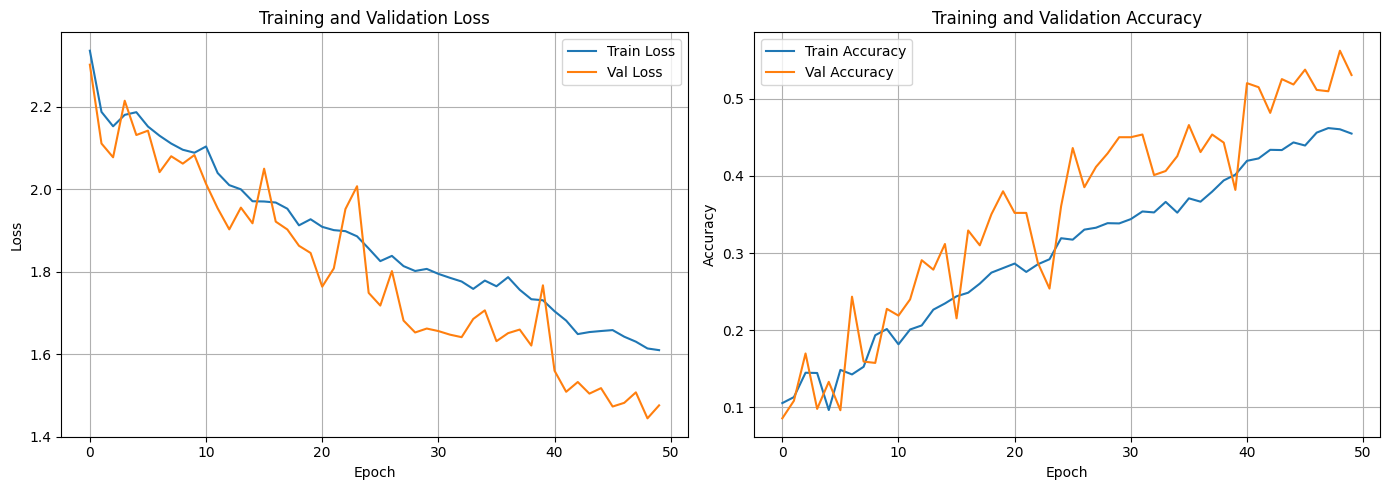


Loaded best model from epoch 49


Testing: 100%|██████████| 60/60 [00:02<00:00, 21.26it/s]



Test Accuracy: 58.36%



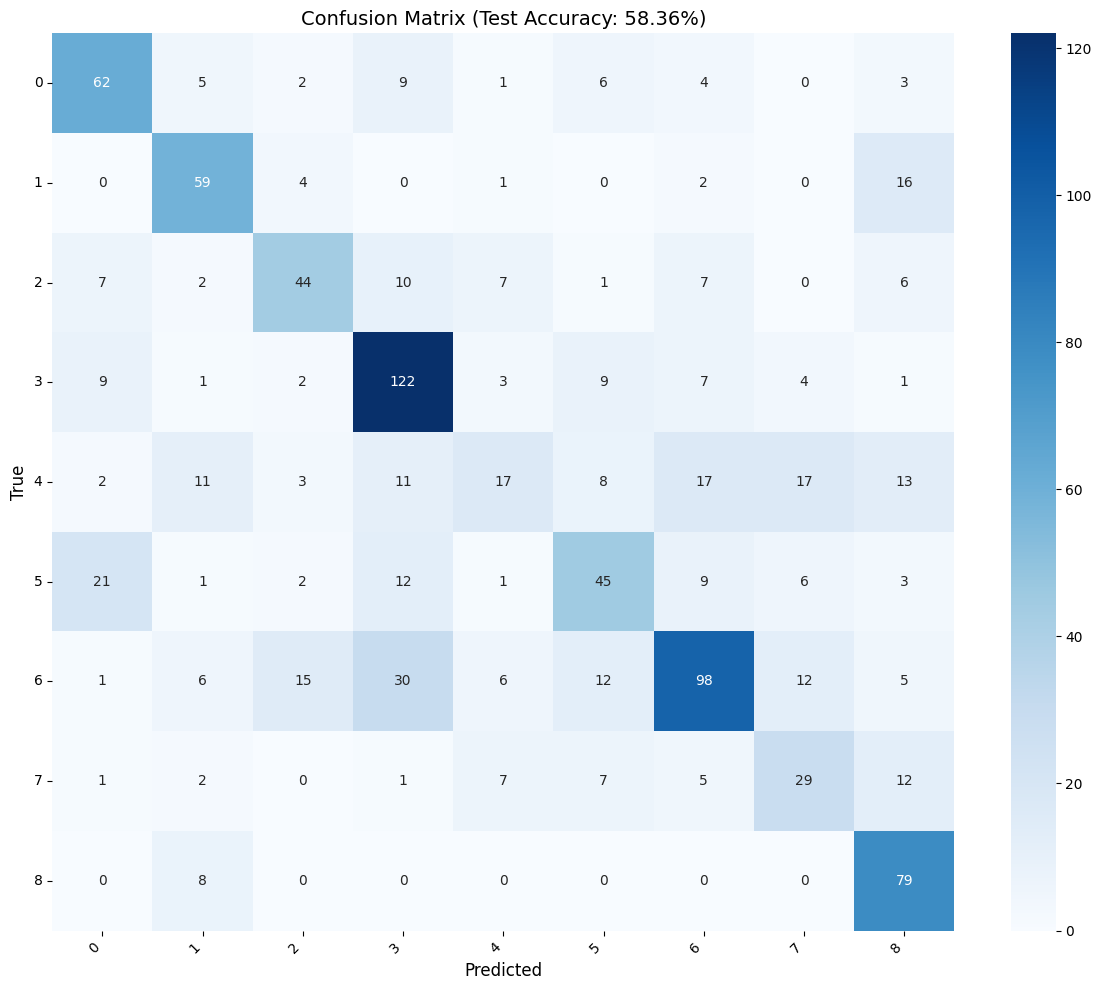


Classification Report:
              precision    recall  f1-score   support

           0     0.6019    0.6739    0.6359        92
           1     0.6211    0.7195    0.6667        82
           2     0.6111    0.5238    0.5641        84
           3     0.6256    0.7722    0.6912       158
           4     0.3953    0.1717    0.2394        99
           5     0.5114    0.4500    0.4787       100
           6     0.6577    0.5297    0.5868       185
           7     0.4265    0.4531    0.4394        64
           8     0.5725    0.9080    0.7022        87

    accuracy                         0.5836       951
   macro avg     0.5581    0.5780    0.5561       951
weighted avg     0.5737    0.5836    0.5669       951


Per-Class Accuracy:
0                   :  67.39% (92 samples)
1                   :  71.95% (82 samples)
2                   :  52.38% (84 samples)
3                   :  77.22% (158 samples)
4                   :  17.17% (99 samples)
5                   :  45.00% (100

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 0. Device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 1. Load data
# ---------------------------
image_array = np.load("images.npy", allow_pickle=True)
labels = np.load("labels.npy", allow_pickle=True)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")
print(f"Classes: {encoder.classes_}")
print(f"Class distribution: {np.bincount(y)}")

# Train/Val/Test split
train_idx, test_idx = train_test_split(
    np.arange(len(y)), test_size=0.2, random_state=42, stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.15, random_state=42, stratify=y[train_idx]
)

print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}, Test size: {len(test_idx)}")

# ---------------------------
# 2. Dataset class
# ---------------------------
class WasteDataset(Dataset):
    def __init__(self, images, labels, indices, transform=None):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        img = self.images[i].astype(np.uint8)
        label = self.labels[i]
        img = np.expand_dims(img, axis=-1)  # (H,W,1)
        if self.transform:
            img = self.transform(img)
        return img, label

# ---------------------------
# 3. Enhanced Transforms
# ---------------------------
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB for pretrained models
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = WasteDataset(image_array, y, train_idx, transform=train_transform)
val_dataset = WasteDataset(image_array, y, val_idx, transform=val_transform)
test_dataset = WasteDataset(image_array, y, test_idx, transform=val_transform)

# Increase batch size and add workers
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0, pin_memory=True)

# ---------------------------
# 4. Model Selection
# ---------------------------
# Option 1: Custom Improved CNN
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.adapt_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.fc1 = nn.Linear(512*4*4, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = self.adapt_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Option 2: Transfer Learning with ResNet50 (RECOMMENDED)
def create_resnet_model(num_classes, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last few layers for fine-tuning
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.layer3.parameters():
        param.requires_grad = True
    
    # Replace final layer
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

# Option 3: EfficientNet (Alternative)
def create_efficientnet_model(num_classes, pretrained=True):
    model = models.efficientnet_b0(pretrained=pretrained)
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last layers
    for param in model.features[-3:].parameters():
        param.requires_grad = True
    
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.classifier[1].in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model

# Choose model (change here to try different models)
USE_TRANSFER_LEARNING = False

if USE_TRANSFER_LEARNING:
    print("Using ResNet50 with Transfer Learning")
    model = create_resnet_model(num_classes, pretrained=True)
else:
    print("Using Custom Improved CNN")
    model = ImprovedCNN(num_classes, input_channels=3)

model = model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ---------------------------
# 5. Label Smoothing Loss
# ---------------------------
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, weight=None):
        super().__init__()
        self.epsilon = epsilon
        self.weight = weight
    
    def forward(self, output, target):
        n_class = output.size(1)
        log_preds = F.log_softmax(output, dim=1)
        loss = -log_preds.sum(dim=1).mean()
        nll = F.nll_loss(log_preds, target, weight=self.weight)
        return (1 - self.epsilon) * nll + self.epsilon * loss / n_class

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y[train_idx]),
    y=y[train_idx]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

# Use label smoothing
criterion = LabelSmoothingCrossEntropy(epsilon=0.1, weight=class_weights)

# ---------------------------
# 6. Optimizer with different learning rates
# ---------------------------
if USE_TRANSFER_LEARNING:
    # Different learning rates for different layers
    optimizer = optim.Adam([
        {'params': model.fc.parameters(), 'lr': 0.001},
        {'params': model.layer4.parameters(), 'lr': 0.0001},
        {'params': model.layer3.parameters(), 'lr': 0.00005}
    ], weight_decay=1e-4)
else:
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7
)

# Cosine annealing (alternative scheduler)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# ---------------------------
# 7. Training loop with all improvements
# ---------------------------
num_epochs = 50
best_val_acc = 0
patience = 10
trigger_times = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), 
                desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for i, (X_batch, y_batch) in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    
    with torch.no_grad():
        for X_batch, y_batch in loop_val:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            loop_val.set_postfix(loss=val_loss/total, acc=correct/total)

    val_loss = val_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, "best_model.pth")
        print(f"✓ Best model saved with val_acc: {val_acc:.4f}")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

# ---------------------------
# 8. Plot training history
# ---------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 9. Test evaluation
# ---------------------------
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")

model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    loop_test = tqdm(test_loader, desc="Testing")
    for X_batch, y_batch in loop_test:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n{'='*50}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"{'='*50}\n")

# ---------------------------
# 10. Confusion matrix
# ---------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix (Test Accuracy: {test_acc*100:.2f}%)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 11. Classification report
# ---------------------------
print("\nClassification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=[str(c) for c in encoder.classes_], digits=4))

# ---------------------------
# 12. Per-class accuracy
# ---------------------------
print("\nPer-Class Accuracy:")
print("="*70)
for i, class_name in enumerate(encoder.classes_):
    class_mask = np.array(y_true) == i
    if class_mask.sum() > 0:
        class_acc = np.mean(np.array(y_pred)[class_mask] == i)
        print(f"{str(class_name):20s}: {class_acc*100:6.2f}% ({class_mask.sum()} samples)")

print("\n✓ Training complete!")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Final test accuracy: {test_acc*100:.2f}%")